In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import math
import sys

import sklearn
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import r2_score,mean_squared_error,accuracy_score,f1_score
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor


np.random.seed(0)

<font size="5">
Let's import our data and explore it.
</font>

In [2]:
data_base_df = pd.read_csv('Dataset.csv', index_col=0)
data_base_df.drop(['instant'], axis=1, inplace=True)
data_base_df['date'] = pd.to_datetime(data_base_df['date'])
data_base_df.head(3)

,date,season,year,month,hour,weekday,weather,temperature,feeling_temperature,humidity,windspeed,Subscribed,Non-subscribed,Total
0,2011-01-01,winter,0,Jan,0,Sat,Clear or partly cloudy,3.28,3.0014,81.0,0.0,3,13,16
1,2011-01-01,winter,0,Jan,1,Sat,Clear or partly cloudy,2.34,1.9982,80.0,0.0,8,32,40
2,2011-01-01,winter,0,Jan,2,Sat,Clear or partly cloudy,2.34,1.9982,80.0,0.0,5,27,32


<br/><br/>
<font size="5">
Let's look for possible NaN values in the dataset

</font>

In [3]:
data_base_df.isna().sum()

date                   0
season                 0
year                   0
month                  0
hour                   0
weekday                0
weather                0
temperature            0
feeling_temperature    0
humidity               0
windspeed              0
Subscribed             0
Non-subscribed         0
Total                  0
dtype: int64

<br/><br/>
<font size="5">
Let's calculate a few statistics and metrics about our data

</font>

In [4]:
data_base_df.describe()

,year,hour,temperature,feeling_temperature,humidity,windspeed,Subscribed,Non-subscribed,Total
count,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000
mean,0.502561,11.546752,15.358397,15.401157,62.722884,12.736540,35.676218,153.786869,189.463088
std,0.500008,6.914405,9.050138,11.342114,19.292983,8.196795,49.305030,151.357286,181.387599
min,0.000000,0.000000,-7.060000,-16.000000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,0.000000,6.000000,7.980000,5.997800,48.000000,7.001500,4.000000,34.000000,40.000000
50%,1.000000,12.000000,15.500000,15.996800,63.000000,12.998000,17.000000,115.000000,142.000000
75%,1.000000,18.000000,23.020000,24.999200,78.000000,16.997900,48.000000,220.000000,281.000000
max,1.000000,23.000000,39.000000,50.000000,100.000000,56.996900,367.000000,886.000000,977.000000


<br/><br/>
<font size="5">
Data visualization
</font>

In [5]:
# VISUALIZING DATA

# grouping data for each single day
total_each_day = data_base_df.groupby(['date'])[['Non-subscribed', 'Subscribed', 'Total']].sum()
total_each_day = pd.DataFrame({ 'date': total_each_day.index,
                                'Non-subscribed' : total_each_day['Non-subscribed'].values,
                                'Subscribed' : total_each_day['Subscribed'].values,
                                'Total': total_each_day['Total'].values,
                              })


# grouping data by month
total_each_month = data_base_df.groupby(
                [(data_base_df['date'].dt.year),
                (data_base_df['date'].dt.month)]
                )[['Non-subscribed', 'Subscribed', 'Total']].agg('sum')

make_index = lambda x : str(int(x[1])) +"-"+ str(int(x[0]))
new_index = list(map(make_index, total_each_month.index))

total_each_month = pd.DataFrame({'date': new_index,
                                  'Non-subscribed' : total_each_month['Non-subscribed'].values,
                                  'Subscribed' : total_each_month['Subscribed'].values,
                                  'Total': total_each_month['Total'].values,})

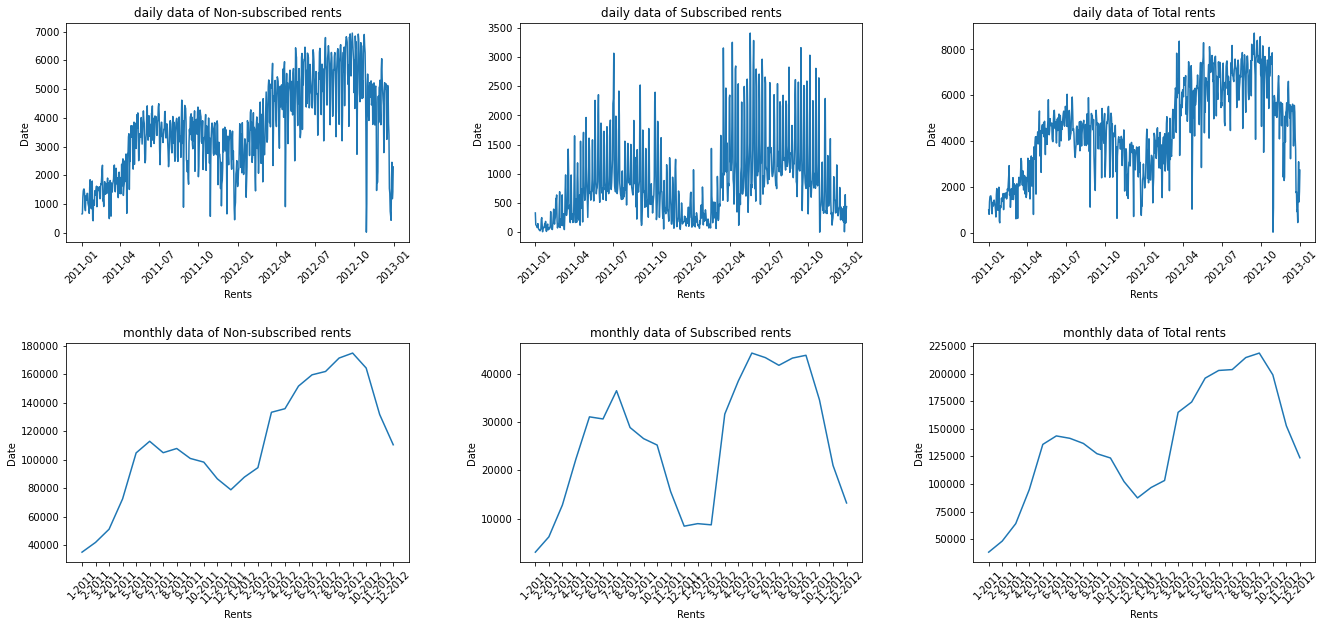

In [6]:
# plotting
fig, axis = plt.subplots(2,3, figsize=(20,10))
fig.tight_layout(pad=8)
titles = ['Non-subscribed', 'Subscribed', 'Total']

categs = total_each_month.columns[1:]

for i in range(len(categs)):

    axis[0,i].plot(total_each_day['date'], total_each_day[categs[i]])
    axis[0,i].set_title(f"daily data of {titles[i]} rents")
    axis[0,i].set_xlabel("Rents")
    axis[0,i].set_ylabel("Date")

    axis[1,i].plot(total_each_month['date'], total_each_month[categs[i]])
    axis[1,i].set_title(f'monthly data of {titles[i]} rents')
    axis[1,i].set_xlabel("Rents")
    axis[1,i].set_ylabel("Date")

    for tick in axis[0,i].get_xticklabels():
      tick.set_rotation(45)
    for tick in axis[1,i].get_xticklabels():
      tick.set_rotation(45)

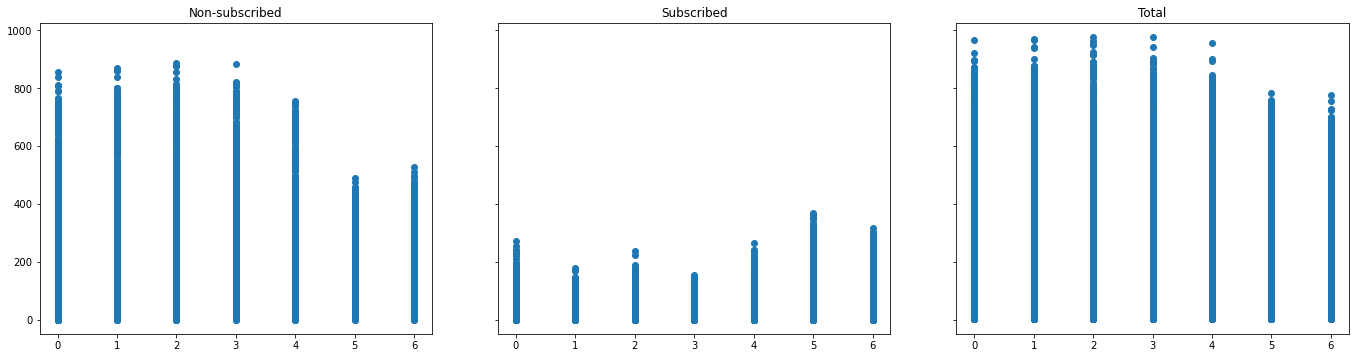

In [7]:
fig, axis = plt.subplots(1,3, figsize=(20,6), sharey=True)
fig.tight_layout(pad=5.0)
axis[0].set_title('Non-subscribed')
axis[0].scatter(data_base_df['date'].dt.weekday, data_base_df['Non-subscribed'])

axis[1].set_title('Subscribed')
axis[1].scatter(data_base_df['date'].dt.weekday, data_base_df['Subscribed'])

axis[2].set_title('Total')
axis[2].scatter(data_base_df['date'].dt.weekday, data_base_df['Total'])

<font size=5>
Intresting to note that subscribed people tend to rent bikes on weekends. A possible explanation for this is that subscribed people are probably residents of the city and tend to use their subscriptions when not at work, which is usually during the weekends.<br/>
On the other side, Non-subscribed people who might be visitors or turists of the city, tend to rent bikes during weekdays. As visitors are usually on holiday for a whole week or more it makes sense that most rentals happen during the weekdays as they tend to return to their home coutry/city during weekends, to get prepared for next week's obligations like work or university.
</font>

<br/><br/>
<font size="5">
Graphical representation of distribution patterns in our data
</font>

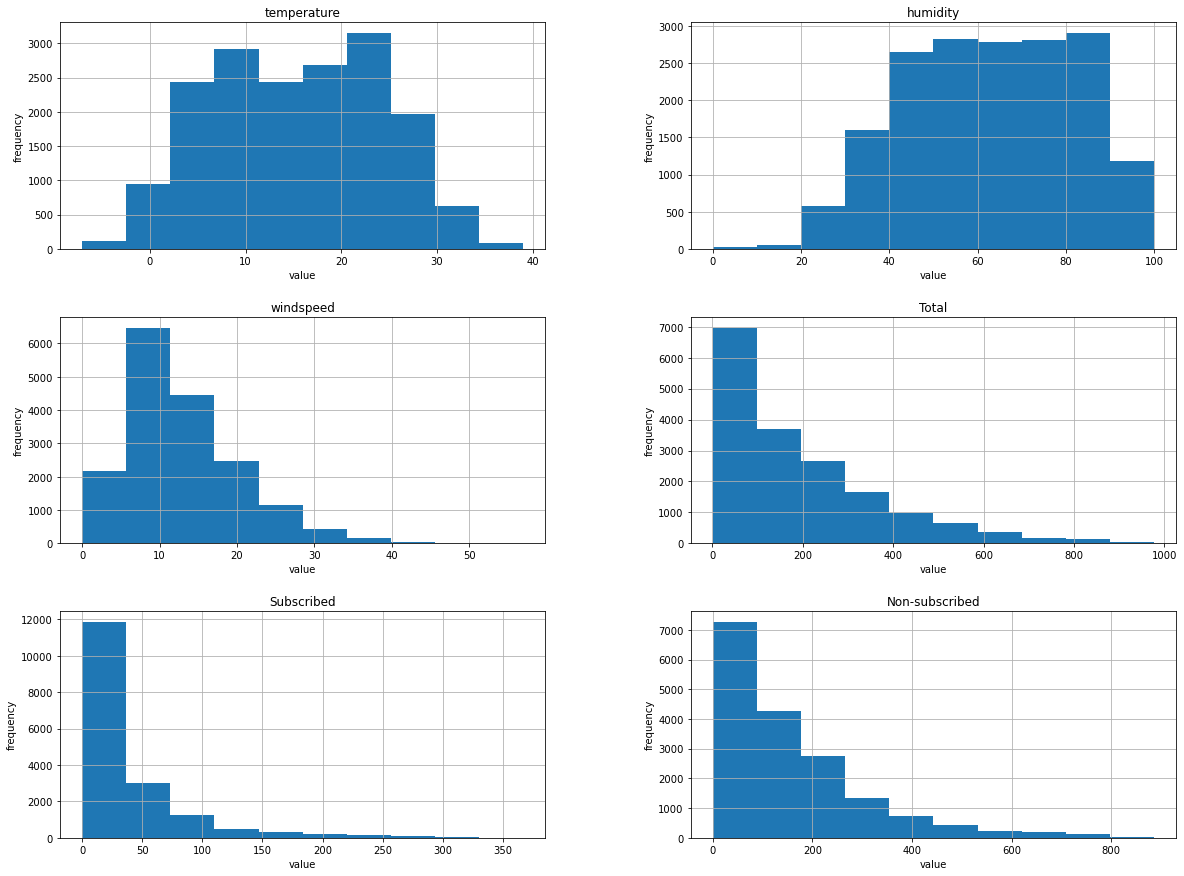

In [8]:
hist_cols = ['temperature', 'humidity', 'windspeed', 'Total', 'Subscribed', 'Non-subscribed']

hists = data_base_df.hist(column=hist_cols, bins=10, figsize=(20,15))
for i in range(len(hists)):
    for j in range(len(hists[i])):
        hists[i][j].set_xlabel('value')
        hists[i][j].set_ylabel('frequency')

<font size="5">
It is clear that most numeric features in our data can belong to a distribution pattern
</font>

In [9]:
# correlations between features
data_base_df.corr()

,year,hour,temperature,feeling_temperature,humidity,windspeed,Subscribed,Non-subscribed,Total
year,1.000000,-0.003867,0.040913,0.039222,-0.083546,-0.008740,0.142779,0.253684,0.250495
hour,-0.003867,1.000000,0.137603,0.133750,-0.276498,0.137252,0.301202,0.374141,0.394071
temperature,0.040913,0.137603,1.000000,0.987672,-0.069881,-0.023125,0.459616,0.335361,0.404772
feeling_temperature,0.039222,0.133750,0.987672,1.000000,-0.051918,-0.062336,0.454080,0.332559,0.400929
humidity,-0.083546,-0.276498,-0.069881,-0.051918,1.000000,-0.290105,-0.347028,-0.273933,-0.322911
windspeed,-0.008740,0.137252,-0.023125,-0.062336,-0.290105,1.000000,0.090287,0.082321,0.093234
Subscribed,0.142779,0.301202,0.459616,0.454080,-0.347028,0.090287,1.000000,0.506618,0.694564
Non-subscribed,0.253684,0.374141,0.335361,0.332559,-0.273933,0.082321,0.506618,1.000000,0.972151
Total,0.250495,0.394071,0.404772,0.400929,-0.322911,0.093234,0.694564,0.972151,1.000000


<font size='5'>
From the correlations we can see that temperature is very highly correlated to feeling_temperature (0.98 correlation) and therefore we cound drop one of the two columns to avoid multicollinearity.
</font>

<br/><br/>
<font size="5">
Let's now look for outliers
</font>

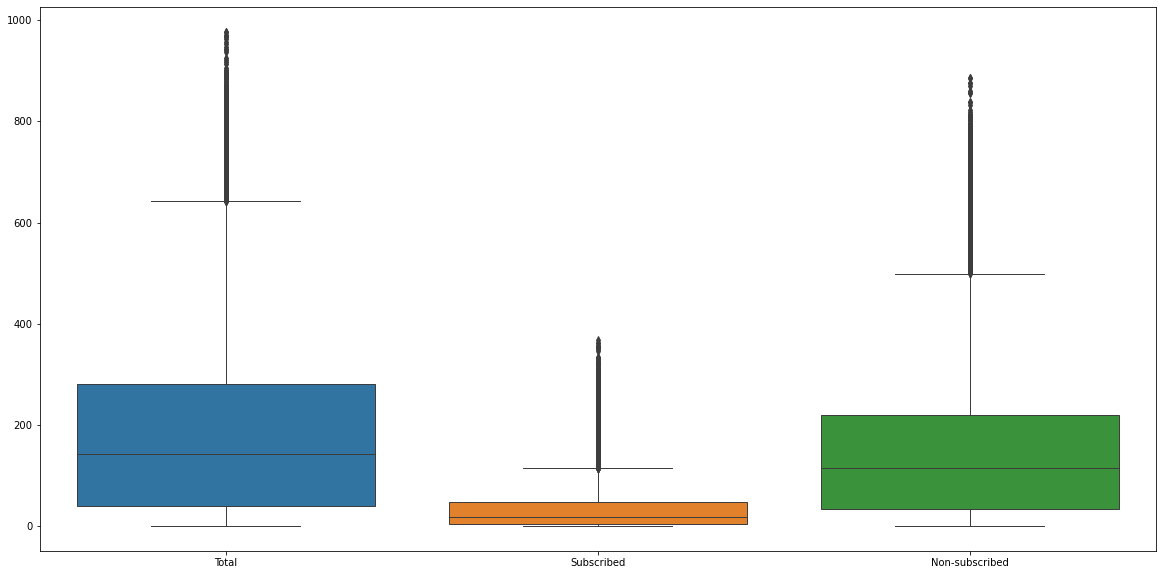

In [10]:
a4_dims = (20, 10)
fig, ax = plt.subplots(figsize=a4_dims)
g = sns.boxplot(data=data_base_df[['Total', 'Subscribed', 'Non-subscribed']],linewidth=1,ax=ax)

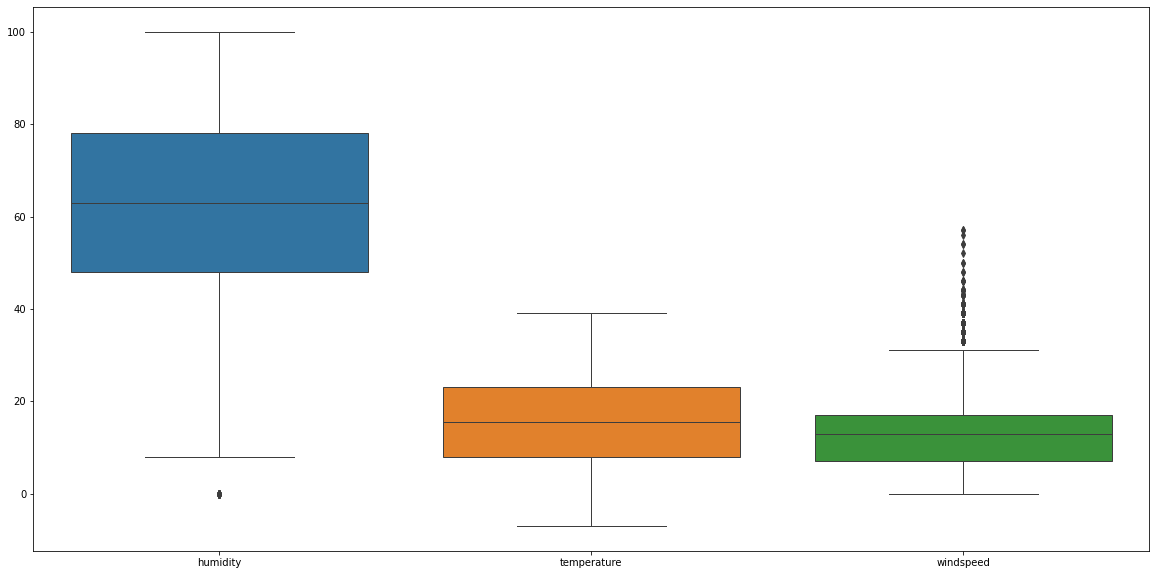

In [11]:
a4_dims = (20, 10)
fig, ax = plt.subplots(figsize=a4_dims)
g = sns.boxplot(data=data_base_df[['humidity', 'temperature', 'windspeed']],linewidth=1,ax=ax)

<font size='5'> There are a lot of outliers in our prediction variables, we will later address them by transforming the with the natural logarithm and the square root.
<br/>
Windspeed also contains a lot of outliers, it would be a good idea to either transform those values or drop the column.
</font><br>


<br/><br/>
<font size="5">
Label encoding approach
</font>

In [12]:
# creating label encoded data
label_enc_df = data_base_df.copy()
label_encoder = LabelEncoder()
label_enc_df['season'] = label_encoder.fit_transform(label_enc_df['season'])
label_enc_df['month'] = label_encoder.fit_transform(label_enc_df['month'])
label_enc_df['weekday'] = label_encoder.fit_transform(label_enc_df['weekday'])
label_enc_df['weather'] = label_encoder.fit_transform(label_enc_df['weather'])

In [13]:
label_enc_df.head(2)

,date,season,year,month,hour,weekday,weather,temperature,feeling_temperature,humidity,windspeed,Subscribed,Non-subscribed,Total
0,2011-01-01,3,0,4,0,2,0,3.28,3.0014,81.0,0.0,3,13,16
1,2011-01-01,3,0,4,1,2,0,2.34,1.9982,80.0,0.0,8,32,40


In [14]:
# creating train and test sets
label_enc_df = label_enc_df.drop(['date','feeling_temperature'], axis=1)
X_label_enc = label_enc_df.drop(['Total', 'Subscribed','Non-subscribed'],axis=1)
y_label_enc = label_enc_df[['Non-subscribed', 'Subscribed', 'Total' ]]
X_train_label_enc, X_test_label_enc, y_train_label_enc, y_test_label_enc = train_test_split(X_label_enc, y_label_enc, test_size=0.5)

In [15]:
# fit and evaluate model
label_enc_lr = LinearRegression()
label_enc_lr.fit(X_train_label_enc, y_train_label_enc['Total'])
label_enc_preds = label_enc_lr.predict(X_test_label_enc)
print("single r2 score:",r2_score(y_test_label_enc['Total'], label_enc_preds))

label_enc_cross_val = cross_val_score(label_enc_lr, X_test_label_enc,y_test_label_enc['Total'],scoring='r2')
print(f"Mean of cross validation r2 score: {np.mean(label_enc_cross_val)}")

single r2 score: 0.3980899478047252
Mean of cross validation r2 score: 0.3985574128403836


<font size="5">
As expected the label encoded model does not perform well, with an r2 score of only 0.39. This happens because label encoding does not keep track of the cyclical properties of some featuers of our data like for the date.
</font>

<br/><br/><font size="5">Mixed one hot encoding and cyclic labeling approach</font>

In [16]:
# checking date data + preprocessing to make it cyclical as it may yield better results

mixed_approach_df = data_base_df.copy()

def cyclic_sin(n_categs):
    transformation = lambda value : np.sin(math.pi*value/n_categs)
    return transformation

def cyclic_cos(n_categs):
    transformation = lambda value : np.cos(math.pi*value/n_categs)
    return transformation

# creating new columns to store sine and cosine values
mixed_approach_df['year_sin'] =  mixed_approach_df['date'].dt.year.map(cyclic_sin(
                        mixed_approach_df['date'].dt.year.nunique()))
mixed_approach_df['month_sin'] =  mixed_approach_df['date'].dt.month.map(cyclic_sin(
                        mixed_approach_df['date'].dt.month.nunique()))
mixed_approach_df['weekday_sin'] = mixed_approach_df['date'].dt.weekday.map(
                        cyclic_sin(mixed_approach_df['date'].dt.weekday.nunique()))
mixed_approach_df['hour_sin'] = mixed_approach_df['hour'].map(
                        cyclic_sin(mixed_approach_df['hour'].nunique()))

mixed_approach_df['year_cos'] =  mixed_approach_df['date'].dt.year.map(cyclic_cos(
                        mixed_approach_df['date'].dt.year.nunique()))
mixed_approach_df['month_cos'] =  mixed_approach_df['date'].dt.month.map(cyclic_cos(
                        mixed_approach_df['date'].dt.month.nunique()))
mixed_approach_df['weekday_cos'] = mixed_approach_df['date'].dt.weekday.map(
                        cyclic_cos(mixed_approach_df['date'].dt.weekday.nunique()))
mixed_approach_df['hour_cos'] = mixed_approach_df['hour'].map(
                        cyclic_cos(mixed_approach_df['hour'].nunique()))

# one hot encoding of categorical variables
mixed_approach_df = pd.get_dummies(mixed_approach_df, columns=['weather', 'season'])

In [17]:
# split data
mixed_approach_processed_df = mixed_approach_df.drop(['date','year',
                                                        'month','hour','weekday',
                                                        'feeling_temperature', 'windspeed'], axis=1)

mixed_approach_X = mixed_approach_processed_df.drop(['Total', 'Subscribed','Non-subscribed'],axis=1)
mixed_approach_y = mixed_approach_processed_df[['Non-subscribed', 'Subscribed', 'Total' ]]

X_train_cyc, X_test_cyc, y_train_cyc, y_test_cyc = train_test_split(mixed_approach_X, mixed_approach_y, test_size=0.5)

In [18]:
# fit and evaluate model
mixed_lr = LinearRegression()
mixed_lr.fit(X_train_cyc, y_train_cyc['Total'])
mixed_lr_preds = mixed_lr.predict(X_test_cyc)
print("single r2 score:",r2_score(y_test_cyc['Total'], mixed_lr_preds))

mixed_lr_cv = cross_val_score(mixed_lr, X_test_cyc,y_test_cyc['Total'],scoring='r2')
print(f"Mean of cross validation r2 score: {np.mean(mixed_lr_cv)}")

single r2 score: 0.5023497542595696
Mean of cross validation r2 score: 0.5013739826399977


<font size="5">

<br/><br/>
<font size="5">
Let's see if test size influences our model's performance
</font>

In [19]:
# Create different linear regression models to identify how its performance varies based on how large the training set is
test_sample_sizes = [0.05, 0.1, 0.2, 0.3, 0.4, 0.5]
mixed_approach_mse = []
mixed_approach_r2 = []
mixed_approach_models = []

for i in test_sample_sizes:
    
    mixed_approach_train_X, mixed_approach_test_X, mixed_approach_train_y, mixed_approach_test_y = train_test_split(mixed_approach_X, mixed_approach_y, test_size=i)

    mixed_lr = LinearRegression()
    mixed_lr.fit(mixed_approach_train_X, mixed_approach_train_y['Total'])
    mixed_approach_models.append(mixed_lr)
    mixed_lr_preds = mixed_lr.predict(mixed_approach_test_X)
    
    mixed_approach_mse_aux = mean_squared_error(mixed_approach_test_y['Total'], mixed_lr_preds)
    mixed_approach_mse.append(mixed_approach_mse_aux)
    
    mixed_approach_r2_aux = r2_score(mixed_approach_test_y['Total'], mixed_lr_preds)
    mixed_approach_r2.append(mixed_approach_r2_aux)

Text(0, 0.5, 'R2')

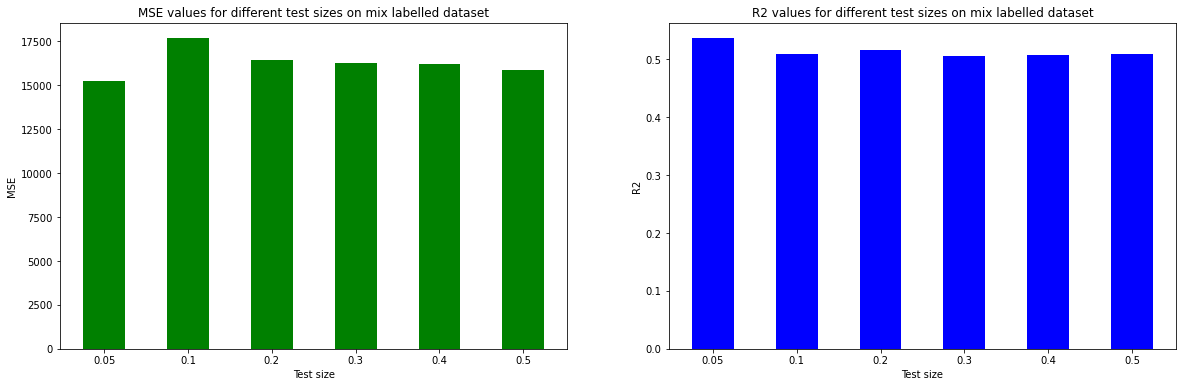

In [20]:
test_sample_size_indexes = [str(x) for x in test_sample_sizes]

fig, axis = plt.subplots(1,2, figsize=(20,6))

axis[0].set_title('MSE values for different test sizes on mix labelled dataset')
axis[0].bar(test_sample_size_indexes, mixed_approach_mse, color ='green', width = 0.5)
axis[0].set_xlabel("Test size")
axis[0].set_ylabel("MSE")

axis[1].set_title('R2 values for different test sizes on mix labelled dataset')
axis[1].bar(test_sample_size_indexes, mixed_approach_r2, color ='blue', width = 0.5)
axis[1].set_xlabel("Test size")
axis[1].set_ylabel("R2")

In [21]:
transformed_target_results_df = pd.DataFrame({  "R2 scores" : mixed_approach_r2, 
                                                "MSE values": mixed_approach_mse },
                                                index = test_sample_sizes)
transformed_target_results_df.index.name = 'Test sample size'
print(transformed_target_results_df)

                  R2 scores    MSE values
Test sample size                         
0.05               0.536326  15246.174382
0.10               0.509521  17686.670387
0.20               0.515378  16422.610798
0.30               0.504968  16248.641266
0.40               0.508069  16227.812077
0.50               0.508980  15891.783967


<font size="5">
The size of the test data does not influence much the r2 score and MSE values. 
<br/>
In addition, we can see that cyclical encoding of time data works better than the label encoding.
</font>

<br/><br/>
<h1>Full One Hot Encoding for all categorical values</h1>

In [22]:
full_oh_base_df = data_base_df.copy()

# preprocessing
full_oh_base_df.drop(['date'], axis=1, inplace=True)
full_oh_base_df = pd.get_dummies(full_oh_base_df, 
                                columns=['weather', 'season', 'year',
                                        'weekday', 'month', 'hour'], 
                                        drop_first=True)
full_oh_base_df.head(3)

,temperature,feeling_temperature,humidity,windspeed,Subscribed,Non-subscribed,Total,weather_Heavy rain,weather_Light rain,weather_Mist,...,hour_14,hour_15,hour_16,hour_17,hour_18,hour_19,hour_20,hour_21,hour_22,hour_23
0,3.28,3.0014,81.0,0.0,3,13,16,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2.34,1.9982,80.0,0.0,8,32,40,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,2.34,1.9982,80.0,0.0,5,27,32,0,0,0,...,0,0,0,0,0,0,0,0,0,0


<font size="5">
It is intresting to note that one hot encoding the hour data column yields a lot better results that leaving it as is.
</font>

In [23]:
# creating train and test data
full_oh_X = full_oh_base_df.drop(['Total', 'Subscribed','Non-subscribed'], axis=1)
full_oh_y = full_oh_base_df[['Non-subscribed', 'Subscribed', 'Total' ]]

full_oh_mse = []
full_oh_r2 = []

for i in test_sample_sizes:
    
    full_oh_train_X, full_oh_test_X, full_oh_train_y, full_oh_test_y = train_test_split(full_oh_X, full_oh_y, test_size=i)

   #model implementation
    full_oh_regressor = LinearRegression()
    full_oh_regressor.fit(full_oh_train_X, full_oh_train_y['Total'])
    full_oh_preds = full_oh_regressor.predict(full_oh_test_X)
    
    full_oh_mse_aux = mean_squared_error(full_oh_test_y['Total'], full_oh_preds)
    full_oh_mse.append(full_oh_mse_aux)
    
    full_oh_r2_aux = r2_score(full_oh_test_y['Total'],full_oh_preds)
    full_oh_r2.append(full_oh_r2_aux)

Text(0, 0.5, 'R2')

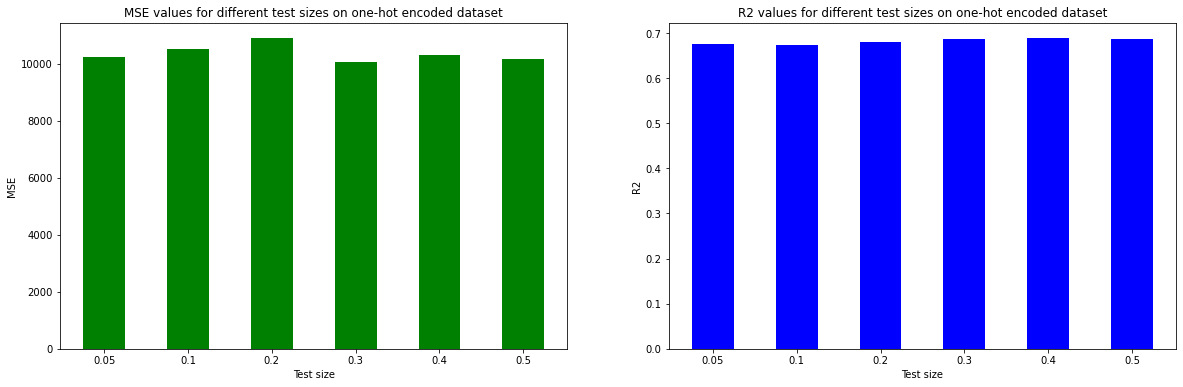

In [24]:
fig, axis = plt.subplots(1,2, figsize=(20,6))

axis[0].set_title('MSE values for different test sizes on one-hot encoded dataset')
axis[0].bar(test_sample_size_indexes, full_oh_mse, color ='green', width = 0.5)
axis[0].set_xlabel("Test size")
axis[0].set_ylabel("MSE")

axis[1].set_title('R2 values for different test sizes on one-hot encoded dataset')
axis[1].bar(test_sample_size_indexes, full_oh_r2, color ='blue', width = 0.5)
axis[1].set_xlabel("Test size")
axis[1].set_ylabel("R2")

In [25]:
transformed_target_results_df = pd.DataFrame({  "R2 scores" : full_oh_r2, 
                                                "MSE values": full_oh_mse },
                                                index = test_sample_sizes)
transformed_target_results_df.index.name = 'Test sample size'
print(transformed_target_results_df)

                  R2 scores    MSE values
Test sample size                         
0.05               0.676121  10231.565000
0.10               0.672752  10519.213715
0.20               0.680150  10888.504376
0.30               0.687493  10063.967919
0.40               0.688610  10301.425385
0.50               0.687869  10152.834566


<font size="5"> 
As it turns out the fully one hot encoded model performs a lot better than the previous models, which concludes the experimentation on the feature preprocessing.
</font>
<br/><br/>

<br/><br/><br/>
<h1>Target transformation</h1>

<font size="4"> Let's transform our target values and see how our model performs. We will focus on the fully one hot encoded dataset since it yielded better r2 results.</font>

In [26]:
transformed_targets_df =  full_oh_y.copy()
to_transform = ['Non-subscribed', 'Subscribed', 'Total']

transformed_target_keys = []
transformed_targets = []

for i in to_transform:
    transformed_targets_df[f'{i}_log'] = np.log(transformed_targets_df[i], where=transformed_targets_df[i] > 0) 
    transformed_targets_df[f'{i}_root'] = np.sqrt(transformed_targets_df[i])
    transformed_targets_df[f'{i}_power'] = np.power(transformed_targets_df[i], 2)

transformed_targets_df.head(3)

,Non-subscribed,Subscribed,Total,Non-subscribed_log,Non-subscribed_root,Non-subscribed_power,Subscribed_log,Subscribed_root,Subscribed_power,Total_log,Total_root,Total_power
0,13,3,16,2.564949,3.605551,169,1.098612,1.732051,9,2.772589,4.000000,256
1,32,8,40,3.465736,5.656854,1024,2.079442,2.828427,64,3.688879,6.324555,1600
2,27,5,32,3.295837,5.196152,729,1.609438,2.236068,25,3.465736,5.656854,1024


In [27]:
(transformed_targets_train_X,
transformed_targets_test_X,
transformed_targets_train_y,
transformed_targets_test_y) = train_test_split(full_oh_X, transformed_targets_df, test_size=0.5)

In [28]:
# we create three linear regression models
transformed_target_models = {
    'lr_log_model' : LinearRegression(), # model trained on the natural logarithm of total rents
    'lr_square_model' : LinearRegression(), # model trained on the square root of total rents
    'lr_power_model' : LinearRegression() # model trained on the power of 2 of total rents
}
transformed_target_keys = ['lr_log_model', 'lr_square_model', 'lr_power_model']
transformed_targets_tot = ['Total_log', 'Total_root', 'Total_power']

transformed_targets_predictions = []
transformed_targets_r2_scores = []
transformed_targets_mses = []
for i in range(len(transformed_targets_tot)):
    # fit model
    transformed_target_models[transformed_target_keys[i]].fit(transformed_targets_train_X, transformed_targets_train_y[transformed_targets_tot[i]])
    # predict
    transformed_targets_predictions.append(transformed_target_models[transformed_target_keys[i]].predict(transformed_targets_test_X))
    # evaluate perdictions
    transformed_targets_r2_scores.append(r2_score(transformed_targets_test_y[transformed_targets_tot[i]],transformed_targets_predictions[i]))
    transformed_targets_mses.append(mean_squared_error(transformed_targets_test_y[transformed_targets_tot[i]],transformed_targets_predictions[i]))

In [29]:
transformed_target_results_df = pd.DataFrame({  "R2 scores" : transformed_targets_r2_scores, 
                                                "MSE values": transformed_targets_mses },
                                                index = ['Natural Logarithm', 'Square root', 'Power of 2'])
print(transformed_target_results_df)

                   R2 scores    MSE values
Natural Logarithm   0.829818  3.735588e-01
Square root         0.789309  9.533646e+00
Power of 2          0.514245  7.028751e+09


<font size="5">
After utilizing some target transformation techniques we notice that the accuracy of our model drastically improves if we consider the natural logarithm of the target value.  However, it degrades if we take the squared value of the target. In general, the natural logarithm works better because it punishes more the high number of outliers with high values present in our target variables of our dataset. 
</font>
<br/>
<br/>
<br/>

<br/><br/>
<font size="5">
Experiments on scaling the data.
</font>

In [30]:
scaled_full_oh_y = full_oh_y.copy()
scaled_full_oh_X = full_oh_X.copy()


scaler = StandardScaler()
scaled_full_oh_X = pd.DataFrame(scaler.fit_transform(full_oh_X), columns=full_oh_X.columns)

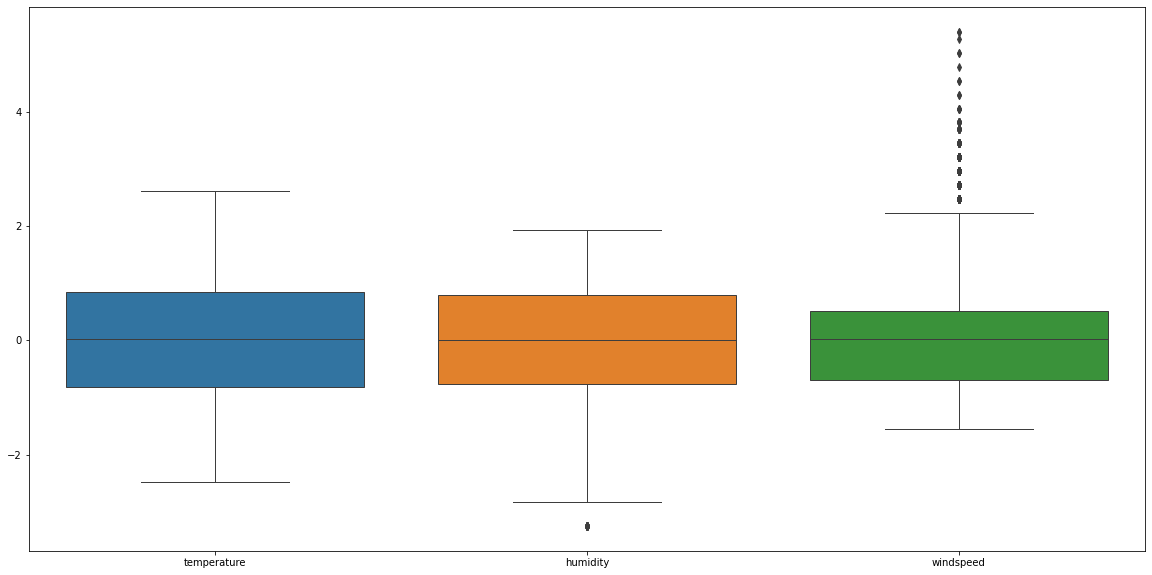

In [31]:
a4_dims = (20, 10)
fig, ax = plt.subplots(figsize=a4_dims)
g = sns.boxplot(data=scaled_full_oh_X[['temperature', 'humidity', 'windspeed']],linewidth=1,ax=ax)

In [32]:
(full_oh_train_X, full_oh_test_X, 
full_oh_train_y, full_oh_test_y) = train_test_split(scaled_full_oh_X, scaled_full_oh_y, test_size=0.2)

scaled_lr_model = LinearRegression()
scaled_lr_model.fit(full_oh_train_X, full_oh_train_y)

scaled_oh_preds = scaled_lr_model.predict(full_oh_test_X)

print("Scaled data r2 score on linear regression model:",round(r2_score(full_oh_test_y, scaled_oh_preds),4))

Scaled data r2 score on linear regression model: 0.6495


<font size='5'>
Trying to scale our data between 0 and 1 did not improve the r2 score of our model.
</font>

<br/><br/><br/><br/><font size="5"> Tree regressor</font>

<font size="5">
Let's create a simple tree regressor to predict bikes rented by Subscribers. 
We will use this model as a threshold to see how tuning hyperparameters can affect the performance
of our model.
</font>

In [33]:
# creating data
(tree_train_X,
tree_test_X,
tree_train_y,
tree_test_y) = train_test_split(full_oh_X, 
                                transformed_targets_df, 
                                test_size=0.5)

In [34]:
# simple tree model
oh_tree_regressor = DecisionTreeRegressor()
oh_tree_regressor.fit(tree_train_X, tree_train_y['Subscribed'])
# single evaluation
preds_oh_tree_regressor = oh_tree_regressor.predict(tree_test_X)
print(r2_score(tree_test_y['Subscribed'], preds_oh_tree_regressor))
# cross validation
np.mean(cross_val_score(oh_tree_regressor, tree_test_X, 
                        tree_test_y['Subscribed']))

0.6097116349158169


0.6089438564604635

<br/>
<font size="5">
We will use GridSearch to find good hyperparameters for our tree regressor model.
<br/>
We will consider the natural logarithm of the Subscribed values since they output better results. 
</font>

In [35]:
#approximately 7 minutes to run

# grid search for Subscribed users
oh_tree_regressor = DecisionTreeRegressor()

# Hyper parameters range intialization for tuning
parameters={"splitter":["best"],
            "max_depth" : [10,20,40,60,100,200],
           "min_samples_leaf": np.linspace(0.00001,0.1, num=10),
           "min_weight_fraction_leaf": np.linspace(0.00001,0.1, num=10),
           "max_features": ["log2",None],
           "max_leaf_nodes": [10,50,100,200,300,500],
           "max_features": ['auto', 'log2'] }

tuning_model_sub=GridSearchCV(oh_tree_regressor,
                                param_grid=parameters,
                                scoring='r2',cv=5)
tuning_model_sub.fit(tree_train_X,tree_train_y['Subscribed_log'])
print("best hyperparameter combination:",tuning_model_sub.best_params_)

best hyperparameter combination: {'max_depth': 40, 'max_features': 'auto', 'max_leaf_nodes': 200, 'min_samples_leaf': 1e-05, 'min_weight_fraction_leaf': 1e-05, 'splitter': 'best'}


In [36]:
# create tree regressor with GridSearch parameters
tree_s = DecisionTreeRegressor()
tree_s.set_params(**tuning_model_sub.best_params_)
# fit the model
tree_s.fit(tree_train_X, tree_train_y['Subscribed_log'])

# evaluate the model
preds_tree_s = tree_s.predict(tree_test_X)
grid_search_res_s = cross_val_score(tree_s, tree_test_X,
                                    tree_test_y['Subscribed_log'],
                                    scoring='r2')

# print results
print("r2 score:",round(r2_score(tree_test_y['Subscribed_log'],preds_tree_s),4))
print(f"The tree regressor with GridSearch hyperparameters reaches a cross validation score of: {round(np.mean(grid_search_res_s), 4)} ")

r2 score: 0.7671
The tree regressor with GridSearch hyperparameters reaches a cross validation score of: 0.7518 


<br/>
<font size="5">
In order to see if the best hyperparameters for Subscribed users are the best for Non-subscribed users
we will run the same grid search but with the target value on the Non-Subscribed rents.
</font>

In [37]:
# grid search for Subscribed users
tree_ns = DecisionTreeRegressor()

#we will use same hyperparameter space as above
tuning_model_ns=GridSearchCV(tree_ns,param_grid=parameters,scoring='r2',cv=5)
tuning_model_ns.fit(tree_train_X,tree_train_y['Non-subscribed_log'])
print("best hyperparameter combination:",tuning_model_ns.best_params_)

best hyperparameter combination: {'max_depth': 100, 'max_features': 'auto', 'max_leaf_nodes': 300, 'min_samples_leaf': 1e-05, 'min_weight_fraction_leaf': 1e-05, 'splitter': 'best'}


In [38]:
# tree regressor with GridSearch parameters on Non-Subscribed
gridsearch_tr_ns = DecisionTreeRegressor()
gridsearch_tr_ns.set_params(**tuning_model_ns.best_params_)
# fit the model
gridsearch_tr_ns.fit(tree_train_X, tree_train_y['Non-subscribed_log'])

# evaluate the model
preds_gridsearch_tr_ns = gridsearch_tr_ns.predict(tree_test_X)
grid_search_res_ns = cross_val_score(gridsearch_tr_ns, tree_test_X, tree_test_y['Non-subscribed_log'],scoring='r2')

# print results
print("single test r2 score:",r2_score(tree_test_y['Non-subscribed_log'],preds_gridsearch_tr_ns))
print(f"The tree regressor with GridSearch hyperparameters reaches a cross validation score of: {np.mean(grid_search_res_ns)} ")

single test r2 score: 0.8466666318941699
The tree regressor with GridSearch hyperparameters reaches a cross validation score of: 0.822123135258604 


<font size="5">
The best hyperparameters used to predict Subscribed rents are different from the hyperparameters used to predict Non-Subscribed rents. This makes sense since the proportion of Subscribed and Non Subscribed rents is generally different for each day, meaning that the two values do not have the same distribution.
</font>

<br/><br/>
<font size="5">
Let's now see how the min_samples_splits and the min_sample_leaf parameters affect the r2 score metric.
</font>

In [39]:
# we will evaluate many decision trees on a variety
# of min_sample_splits values
min_samples_splits = np.linspace(0.0001,1, num=1000)
min_sample_split_r2_scores = []
min_sample_split_mses = []

for i in min_samples_splits:
    oh_tree_regressor = DecisionTreeRegressor(min_samples_split=i)
    oh_tree_regressor.fit(transformed_targets_train_X, transformed_targets_train_y['Subscribed'])

    preds_oh_tree_regressor = oh_tree_regressor.predict(transformed_targets_test_X)

    min_sample_split_r2_scores.append(r2_score(transformed_targets_test_y['Subscribed'], preds_oh_tree_regressor))
    min_sample_split_mses.append(mean_squared_error(transformed_targets_test_y['Subscribed'], preds_oh_tree_regressor))

In [40]:
# we will evaluate many decision trees on a variety
# of min_sample_leafs values
min_sample_leafs = np.linspace(0.0001,0.5, num=1000)
min_sample_leafs_r2_scores = []
min_sample_leafs_mses = []

for i in min_sample_leafs:
    oh_tree_regressor = DecisionTreeRegressor(min_samples_leaf=i)
    oh_tree_regressor.fit(transformed_targets_train_X, transformed_targets_train_y['Subscribed'])

    preds_oh_tree_regressor = oh_tree_regressor.predict(transformed_targets_test_X)

    min_sample_leafs_r2_scores.append(r2_score(transformed_targets_test_y['Subscribed'], preds_oh_tree_regressor))
    min_sample_leafs_mses.append(mean_squared_error(transformed_targets_test_y['Subscribed'], preds_oh_tree_regressor))

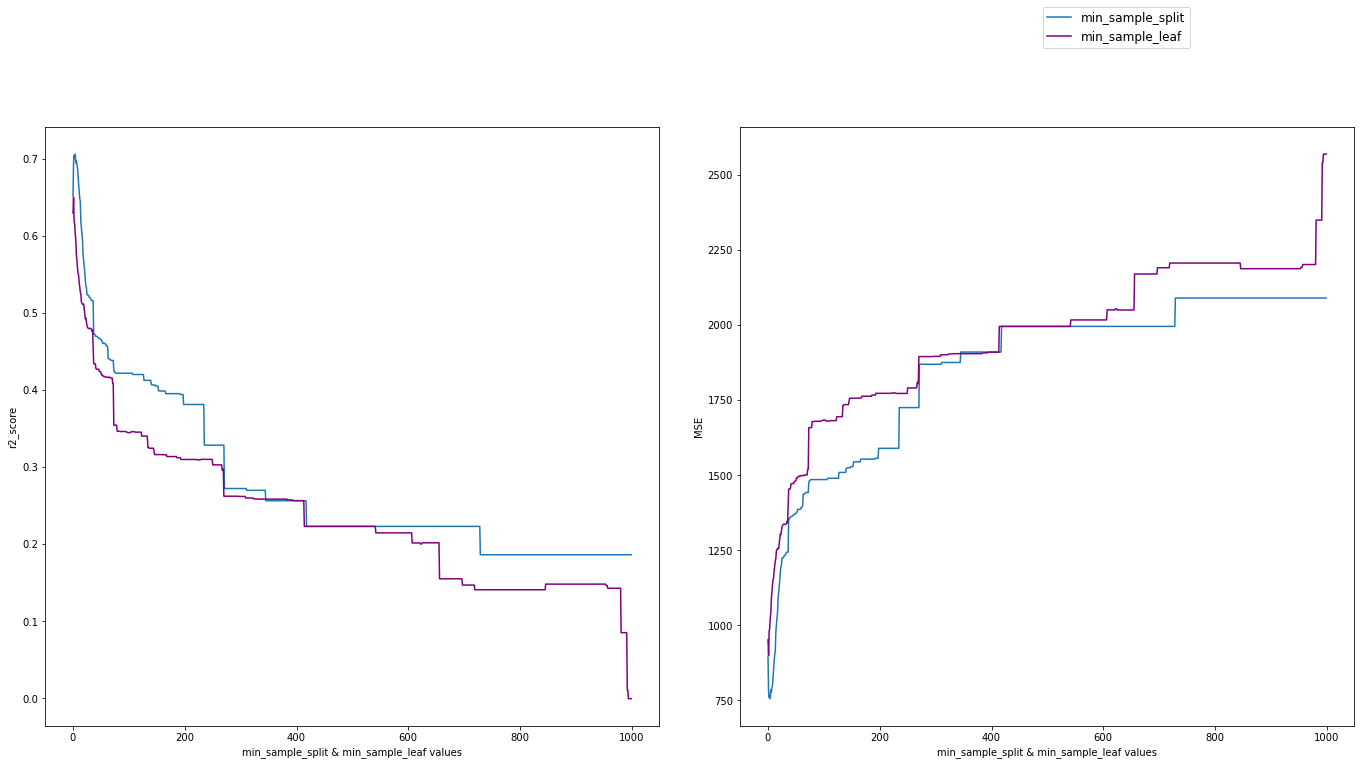

In [41]:
fig, axis = plt.subplots(1,2, figsize=(20,10))
fig.tight_layout(pad=5.0)

axis[0].plot(min_sample_split_r2_scores, label='min_sample_split')
axis[0].plot(min_sample_leafs_r2_scores, label='min_sample_leaf', color='purple')
axis[0].set_xlabel("min_sample_split & min_sample_leaf values")
axis[0].set_ylabel("r2_score")

axis[1].plot(min_sample_split_mses, label='min_sample_split')
axis[1].plot(min_sample_leafs_mses, label='min_sample_split', color="purple")
axis[1].set_xlabel("min_sample_split & min_sample_leaf values")
axis[1].set_ylabel("MSE")

lines, labels = axis[0].get_legend_handles_labels()
fig.legend(lines, labels, loc='upper right', fontsize= 'large',bbox_to_anchor=(0.85,1.1))

In [70]:
print(f"Max r2 for min_sample_split: {np.max(min_sample_split_r2_scores)}")

print(f"Max r2 for min_sample_leafs: {np.max(min_sample_leafs_r2_scores)}")

Max r2 for min_sample_split: 0.7059171382159961
Max r2 for min_sample_leafs: 0.6497959720758629


In [ ]:
min_sample_split_r2_scores

<font size="5">
Changing the min_sample_split can lead to slightly higher r2 score values. The optimal value for min_sample_split is around 0.0001, which gives us an r2 score of 0.75 for the subscribed and 0.82 for Non-Subscribed rents.
</font>
<br/><br/><br/>


<br/><br/>
<font size='5'>
Assignment part 2:
<br/>
<br/>
</font>
<font size='3'>
(The third exercise is dealt with in the Data Preprocessing part of this notebook, above)
</font>

<font size='5'>
1.
</font>

In [42]:
# segment and sort the number of total bikes into bins with pd.cut
oh_df = full_oh_base_df.copy()
oh_df['Classes'] = pd.cut(oh_df.Total, bins=5, labels=range(5))
full_oh_X = oh_df.drop(['Total', 'Subscribed','Non-subscribed','Classes'], axis=1)
full_oh_y = oh_df['Classes']

#Split the dataset in train set and test set
full_oh_train_X, full_oh_test_X, full_oh_train_y, full_oh_test_y = train_test_split(full_oh_X, full_oh_y, test_size=0.3)

<font size="5">
One vs Rest Classifier
</font>

In [43]:
# import Logistic Regression
from sklearn.linear_model import LogisticRegression

#select the One versus Rest model
model = LogisticRegression(multi_class='ovr',max_iter=10000, random_state=0)


# fit model
model.fit(full_oh_train_X, full_oh_train_y)

# make predictions
pred = model.predict(full_oh_test_X)

In [44]:
from sklearn.metrics import classification_report
print(classification_report(full_oh_test_y, pred))

              precision    recall  f1-score   support

           0       0.86      0.92      0.89      3157
           1       0.57      0.64      0.60      1306
           2       0.41      0.22      0.28       527
           3       0.55      0.24      0.34       169
           4       0.83      0.35      0.49        55

    accuracy                           0.75      5214
   macro avg       0.64      0.47      0.52      5214
weighted avg       0.73      0.75      0.73      5214



<font size="5">
One vs One Classifier
</font>

In [45]:
from sklearn.multiclass import OneVsOneClassifier

# implement the one vs one classifier model and apply it to the logistic regression one
model_ovo = OneVsOneClassifier(LogisticRegression(max_iter=10000, random_state=0))

# fit model
model_ovo.fit(full_oh_train_X, full_oh_train_y)

# make predictions
pred_ovo = model_ovo.predict(full_oh_test_X)

print(classification_report(full_oh_test_y, pred_ovo))

              precision    recall  f1-score   support

           0       0.88      0.91      0.89      3157
           1       0.64      0.66      0.65      1306
           2       0.56      0.45      0.50       527
           3       0.47      0.39      0.43       169
           4       0.67      0.51      0.58        55

    accuracy                           0.78      5214
   macro avg       0.64      0.58      0.61      5214
weighted avg       0.77      0.78      0.77      5214



<font size="5">
Let's create a bar char with the F1-scores of the five classes for the OnevsOne and OnevsAll classifiers
</font>

Text(0, 0.5, 'F1-score')

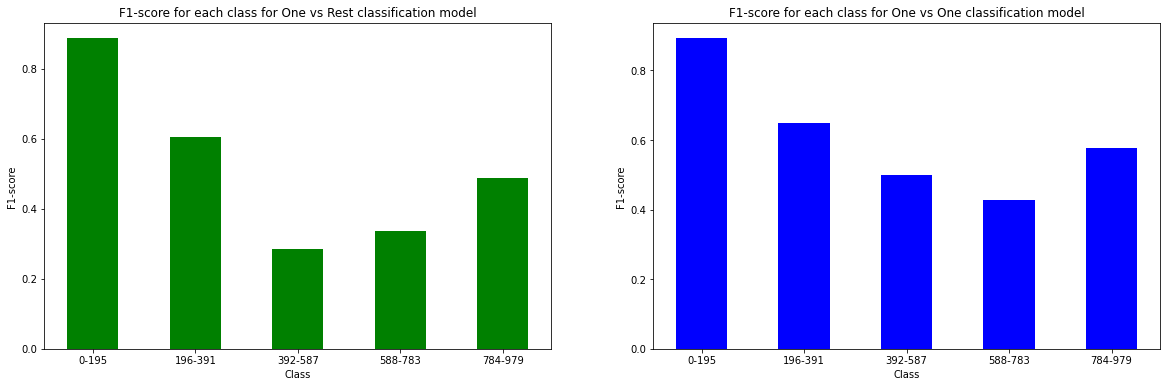

In [46]:
fig, axis = plt.subplots(1,2, figsize=(20,6))
target_names = ['0-195', '196-391', '392-587','588-783','784-979']
classes_indexes = [str(x) for x in target_names]

axis[0].set_title('F1-score for each class for One vs Rest classification model')
axis[0].bar(classes_indexes,f1_score(full_oh_test_y, pred,average=None), color ='green', width = 0.5)
axis[0].set_xlabel("Class")
axis[0].set_ylabel("F1-score")

axis[1].set_title('F1-score for each class for One vs One classification model')
axis[1].bar(classes_indexes,f1_score(full_oh_test_y, pred_ovo,average=None), color ='blue', width = 0.5)
axis[1].set_xlabel("Class")
axis[1].set_ylabel("F1-score")

<font size="5">
The OnevsOne method performs overall better.
<br>
<br>

<font size="5">
2.<br/><br/>
Let's create a perceptron model to predict the weather situation based on other some other features in the data set.
</font>

In [47]:
from sklearn.linear_model import Perceptron
from sklearn.preprocessing import LabelEncoder
from functools import partial
from sklearn.feature_selection import mutual_info_classif
from sklearn.feature_selection import SelectKBest
import random

oh_df=full_oh_base_df.copy()

oh_df.columns = oh_df.columns.str.replace(' ','_')


# We encode the weather to be our target variable
le = LabelEncoder()
weather_le = le.fit_transform(data_base_df['weather'])
oh_df['Weather'] = weather_le

# We subselect our features
scaler = StandardScaler()
oh_df[['temperature', 'humidity', 'windspeed','feeling_temperature']] = scaler.fit_transform(
                        oh_df[['temperature', 'humidity', 'windspeed','feeling_temperature']]
                    )
full_oh_X = oh_df.drop(['weather_Light_rain','weather_Heavy_rain','weather_Mist','Total','Non-subscribed','Subscribed','Weather'], axis=1)
full_oh_y = oh_df['Weather']

# We only take discrete columns of our dataframe
discrete_cols = [i for i in full_oh_X if i not in ['temperature', 'humidity', 'windspeed','feeling_temperature']]
discrete_idx = [full_oh_X.columns.get_loc(i) for i in discrete_cols]


score_func = partial(mutual_info_classif, discrete_features=discrete_idx)
scores_test = []
scores_train = []

full_oh_train_X, full_oh_test_X, full_oh_train_y, full_oh_test_y = train_test_split(full_oh_X, full_oh_y, test_size=0.2, random_state=0)

# We test the model on different seeds
for i in range(30):
    curr_test = []
    curr_train = []
        
    for k in range(1,len(full_oh_X.columns)):

        k_best = SelectKBest(score_func, k=k).fit(full_oh_X, full_oh_y)
        X_train_k = full_oh_train_X[full_oh_train_X.columns[k_best.get_support()]]
        X_test_k = full_oh_test_X[full_oh_test_X.columns[k_best.get_support()]]
        
        ovo = OneVsOneClassifier(Perceptron(random_state=i))
        ovo.fit(X_train_k , full_oh_train_y)
        
        preds_test = ovo.predict(X_test_k)
        preds_train = ovo.predict(X_train_k)
        
        curr_test.append(f1_score(full_oh_test_y, preds_test, average='weighted'))
        curr_train.append(f1_score(full_oh_train_y, preds_train, average='weighted'))
    scores_test.append(curr_test)
    scores_train.append(curr_train)

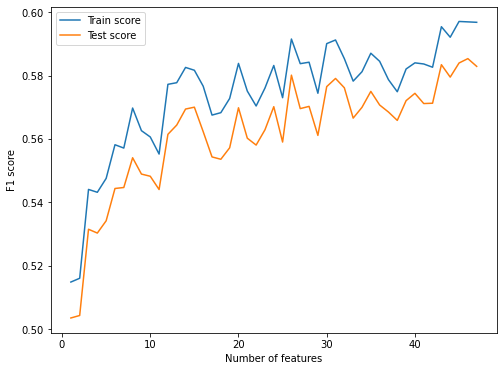

In [48]:
# Plotting results
fig = plt.figure(figsize=(8, 6))
plt.plot(list(range(1,len(full_oh_X.columns))) , np.mean(scores_train,axis=0),label='Train score')
plt.plot(list(range(1,len(full_oh_X.columns))) , np.mean(scores_test, axis=0),label='Test score')
plt.xlabel("Number of features")
plt.ylabel("F1 score")
plt.legend()

<font size="5">
Around 20 to 30 features gives us the best F1 score on both train and test set
</font>
<br/><br/>

<br/> <br/>
<font size="5">
We create a One vs One classifier with 26 features and for all our weather target variables
</font>

In [49]:
from sklearn.metrics import make_scorer

X_new = SelectKBest(score_func=score_func, k=26).fit_transform(full_oh_X, full_oh_y)

full_oh_train_X, full_oh_test_X, full_oh_train_y, full_oh_test_y = train_test_split(X_new, full_oh_y, test_size=0.3, random_state=0)

eta0 = np.linspace(1e-5, 1e-1, 25)

scores_train = []
scores_test = []

# Testing for different seeds
for random_state in range(30):
    score_train = []
    score_test = []

    # we train for different learning rates to check the performance
    for eta in eta0:
        model_perc = OneVsOneClassifier(Perceptron(eta0=eta, random_state=random_state))
        
        model_perc.fit(full_oh_train_X, full_oh_train_y)

        preds_test = model_perc.predict(full_oh_test_X)
        preds_train = model_perc.predict(full_oh_train_X)
        score_test.append(f1_score(full_oh_test_y, preds_test, average='weighted'))
        score_train.append(f1_score(full_oh_train_y, preds_train, average='weighted'))
    scores_test.append(score_test)
    scores_train.append(score_train)

Text(0, 0.5, 'F1 score')

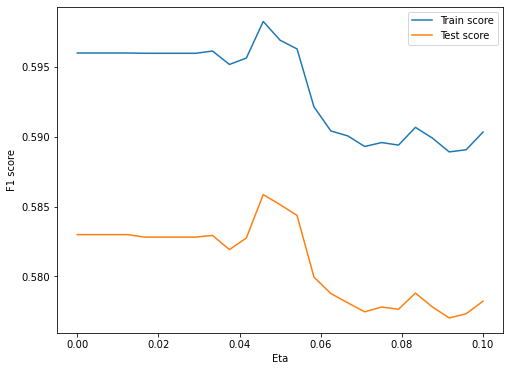

In [50]:
# Plot results
fig = plt.figure(figsize=(8, 6))
plt.plot(eta0 , np.mean(scores_train,axis=0), label='Train score')
plt.plot(eta0 , np.mean(scores_test, axis=0),label='Test score')
plt.legend()
plt.xlabel("Eta")
plt.ylabel("F1 score")

<br/> <br/>
<font size="5">
We create a One vs One classifier with 26 features but only for two weather classes, specifically 'Mist' and 'Clearly or partly cloudy'

In [51]:
cols_keep = ['Mist', 'Clear or partly cloudy']

oh_df['weather'] = data_base_df['weather']
oh_df.loc[oh_df['weather'].isin(cols_keep)]

oh_df.Weather[oh_df.weather == 'Mist'] = 1

full_oh_X = oh_df.drop(['weather_Light_rain','weather_Heavy_rain','weather_Mist','Total','Non-subscribed','Subscribed','Weather','weather'], axis=1)
full_oh_y = oh_df['Weather']

X_new = SelectKBest(score_func=score_func, k=26).fit_transform(full_oh_X, full_oh_y)

full_oh_train_X, full_oh_test_X, full_oh_train_y, full_oh_test_y = train_test_split(X_new, full_oh_y, test_size=0.3, random_state=0)

eta0 = np.linspace(1e-5, 0.1, 25)

scores_train = []
scores_test = []
for random_state in range(30):
    score_train = []
    score_test = []

    for eta in eta0:
        model_perc = OneVsOneClassifier(Perceptron(eta0=eta, random_state=random_state))
        
        model_perc.fit(full_oh_train_X, full_oh_train_y)

        preds_test = model_perc.predict(full_oh_test_X)
        preds_train = model_perc.predict(full_oh_train_X)
        score_test.append(f1_score(full_oh_test_y, preds_test, average='weighted'))
        score_train.append(f1_score(full_oh_train_y, preds_train, average='weighted'))
    scores_test.append(score_test)
    scores_train.append(score_train)




<ipython-input-51-eff36e9f1925>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  oh_df.Weather[oh_df.weather == 'Mist'] = 1


Text(0, 0.5, 'F1 score')

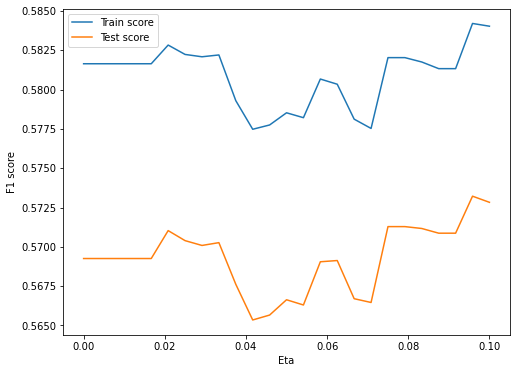

In [52]:
fig = plt.figure(figsize=(8, 6))
plt.plot(eta0 , np.mean(scores_train,axis=0), label='Train score')
plt.plot(eta0 , np.mean(scores_test, axis=0),label='Test score')
plt.legend()
plt.xlabel("Eta")
plt.ylabel("F1 score")

<font size="5">
The best learning rate is around 0 and 0.2. For learning rates greater than 0.2 the error keeps increasing and the F1 score decreases.
</font>
<br/><br/>

<br><br>
<font size="5">
4.<br/>
Let's build a SVM regressor model to predict the number of bike rentals by subscribers and see how using different kernels impacts the performance. 
</font>

In [53]:
from sklearn.svm import SVR
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler

# apply standard scaling on the full one hot encoded data
standard_full_oh= full_oh_base_df.copy()
scaled_features = StandardScaler().fit_transform(standard_full_oh.values)
standard_full_oh = pd.DataFrame(scaled_features, index=standard_full_oh.index, columns=standard_full_oh.columns)


full_oh_X = standard_full_oh.drop(['Total', 'Subscribed','Non-subscribed'], axis=1)
full_oh_y = standard_full_oh['Subscribed']

#Create SVM regressor with different kernels: linear, poly and rbf
kernel_type = ['linear', 'poly', 'rbf' ]
accuracy= []

for item in kernel_type:

  svr = SVR(kernel=item)
  scores = cross_val_score(svr, full_oh_X, full_oh_y, cv=5)
  # calculate the accuracy score in order to identify the best kernel type
  accuracy.append(scores.mean())

print(f"Linear: \t {accuracy[0]} \nPolynomial: \t {accuracy[1]} \nRbf:  \t {accuracy[2]}")

Linear: 	 0.3977951573601143 
Polynomial: 	 0.7420459453865644 
Rbf:  	 0.7812289966533108


<br><br>
<font size="5">
Representation of the r2 score according to the kernels selected through a bar chart
</font>

Text(0, 0.5, 'R2 score')

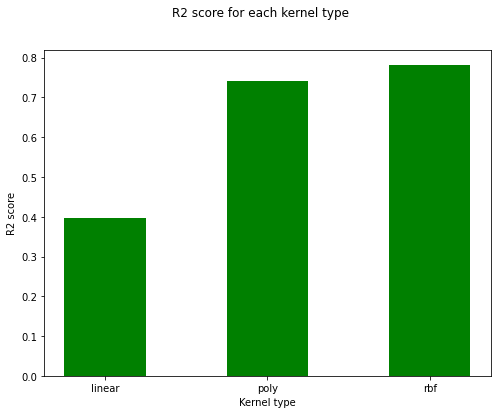

In [54]:
kernel_indexes = [str(x) for x in kernel_type]


fig = plt.figure(figsize=(8, 6))
plt.suptitle('R2 score for each kernel type')
plt.bar(kernel_type, accuracy, color ='green', width = 0.5)
plt.xlabel("Kernel type")
plt.ylabel("R2 score")

<font size="5">
From the bar chart we can conclude that the RBF kernel performs better than the other two. The linear one is the worse.
</font>

<br/><br/>
<font size="5">
5.
</font>

Text(0.5, 1.0, 'Weekday')

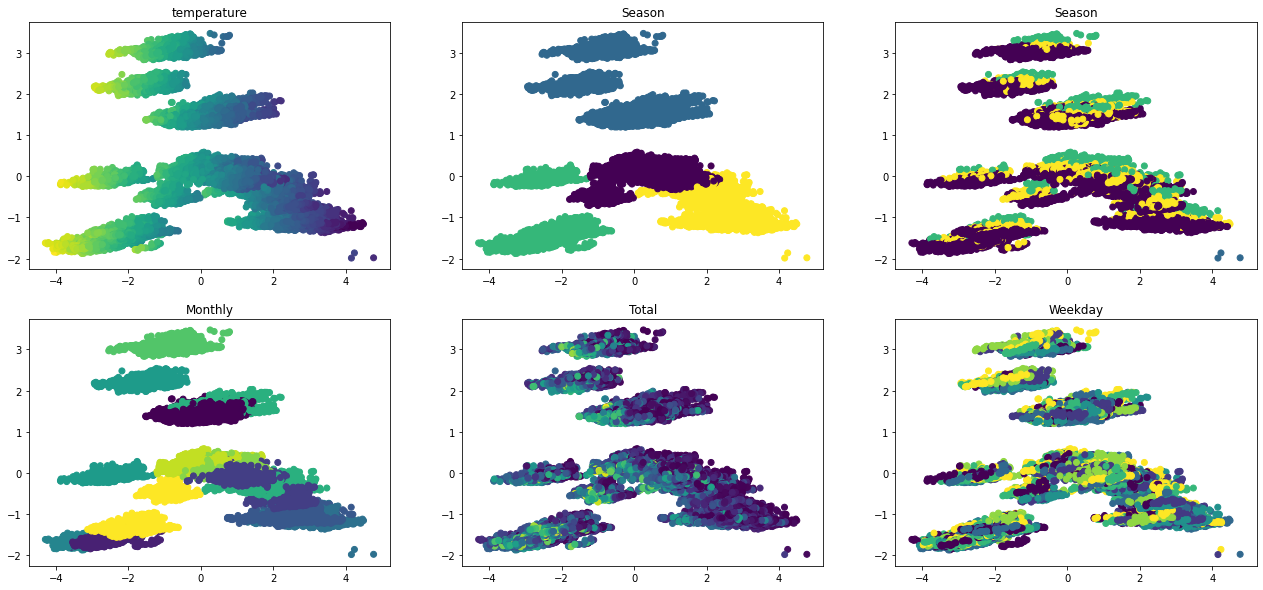

In [55]:
# pca with ALL one hot encoded features

tree_data_df = full_oh_base_df.copy()
full_oh_X = tree_data_df.drop(['Total', 'Subscribed','Non-subscribed'], axis=1)
full_oh_y = tree_data_df['Total']


x_std_pca_full = StandardScaler().fit_transform(full_oh_X)

pca = PCA(n_components=2)
pca.fit(x_std_pca_full)
pca_features = pca.transform(x_std_pca_full).T

fig, ax = plt.subplots(2,3,figsize=(22,10))
ax[0,0].scatter(pca_features[0],pca_features[1],c=label_enc_df['temperature'])
ax[0,0].set_title('temperature')
ax[0,1].scatter(pca_features[0],pca_features[1],c=label_enc_df['season'])
ax[0,1].set_title('Season')
ax[0,2].scatter(pca_features[0],pca_features[1],c=label_enc_df['weather'])
ax[0,2].set_title('Season')
ax[1,0].scatter(pca_features[0],pca_features[1],c=label_enc_df['month'])
ax[1,0].set_title('Monthly')
ax[1,1].scatter(pca_features[0],pca_features[1],c=label_enc_df['Total'])
ax[1,1].set_title('Total')
ax[1,2].scatter(pca_features[0],pca_features[1],c=label_enc_df['weekday'])
ax[1,2].set_title('Weekday')

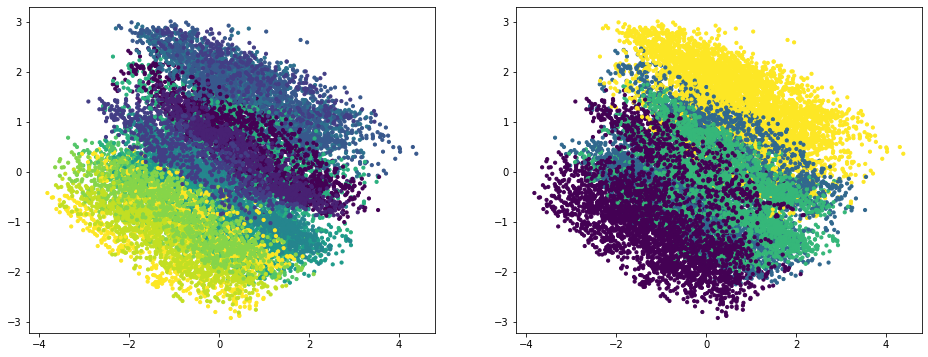

In [56]:
# pca on label encoded dataset
pca_features_ns = label_enc_df.drop(['Subscribed', 'Non-subscribed', 'Total'],axis=1)
x_std_label = StandardScaler().fit_transform(pca_features_ns)

pca = PCA(n_components=2)
pca.fit(x_std_label)
pca_transformed_data_label = pca.transform(x_std_label).T

fig, ax = plt.subplots(1,2,figsize=(16,6))
ax[0].scatter(pca_transformed_data_label[0],pca_transformed_data_label[1],s=10,c=label_enc_df['month'])
ax[1].scatter(pca_transformed_data_label[0],pca_transformed_data_label[1],s=10,c=label_enc_df['season'])

<font size="5">
Utilizing pca on the full datasets, (both the one hot encoded and the label encoded), and colouring features by season and month are the most promising grouping techniques to make sense of our data. Let's now try feature subselection.
</font>
<br/><br/></br>

In [57]:
# PCA with feature subselection on the one hot encoded dataset
full_oh_X_sub = full_oh_X.copy()

# the filters are the columns we will remove
# for the one hot encoded features we will remove all the corresponding columns
filters = ['temperature', 'humidity', 'windspeed', 'weather', 'season', 'hour']

pca_subs = []
ignored = []
for i in filters:
    ignored.append(i)

    # take all dataframe except the column(s) to ignore
    curr_df = full_oh_X_sub[full_oh_X_sub.columns.drop(
                                    list(full_oh_X_sub.filter(regex=i)))]
    x_std_label = StandardScaler().fit_transform(curr_df)


    pca = PCA(n_components=2)
    pca.fit(x_std_label)
    pca_transformed_data_oh = pca.transform(x_std_label).T
    pca_subs.append([pca_transformed_data_oh[0],
                        pca_transformed_data_oh[1]])

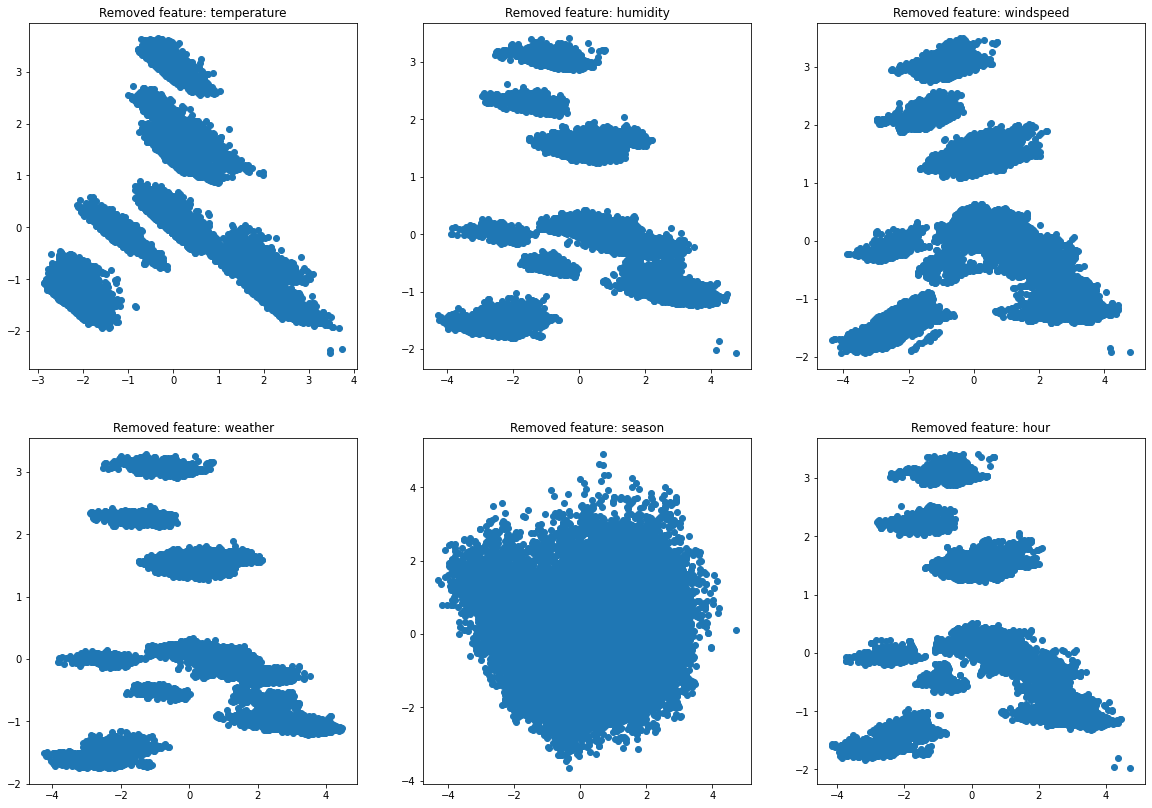

In [58]:
# Plot PCA with feature subselection
counter = 0
fig, ax = plt.subplots(2,3,figsize=(20,14))
for i in range(2):
    for j in range(3):
        ax[i,j].set_title("Removed feature: "+ignored[counter])
        ax[i,j].scatter(pca_subs[counter][0],pca_subs[counter][1])
        counter += 1

<font size="5">
The plots indicate that the most important feature is the Season feature. Without it the clustering deteriorates dramatically
</font>

<br/><br/>
<font size="5">
6.
</font>

In [59]:
# We will use agglomerative clustering as hierarchical clustering
# We will create 5 classes and assign each target value to a class

from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram

oh_df = full_oh_base_df.copy()
oh_df['Classes'] = pd.cut(oh_df.Total, bins=5, labels=range(5))

full_oh_X = oh_df.drop(['Total', 'Subscribed','Non-subscribed', 'Classes'], axis=1)
full_oh_y = oh_df[['Non-subscribed', 'Subscribed', 'Total', 'Classes' ]]

In [60]:
# TAKEN FROM SKLEARN TUTORIAL:
# https://scikit-learn.org/stable/auto_examples/cluster/plot_agglomerative_dendrogram.html

def plot_dendrogram(model, **kwargs):
    # Create linkage matrix and then plot the dendrogram

    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack(
        [model.children_, model.distances_, counts]
    ).astype(float)

    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)

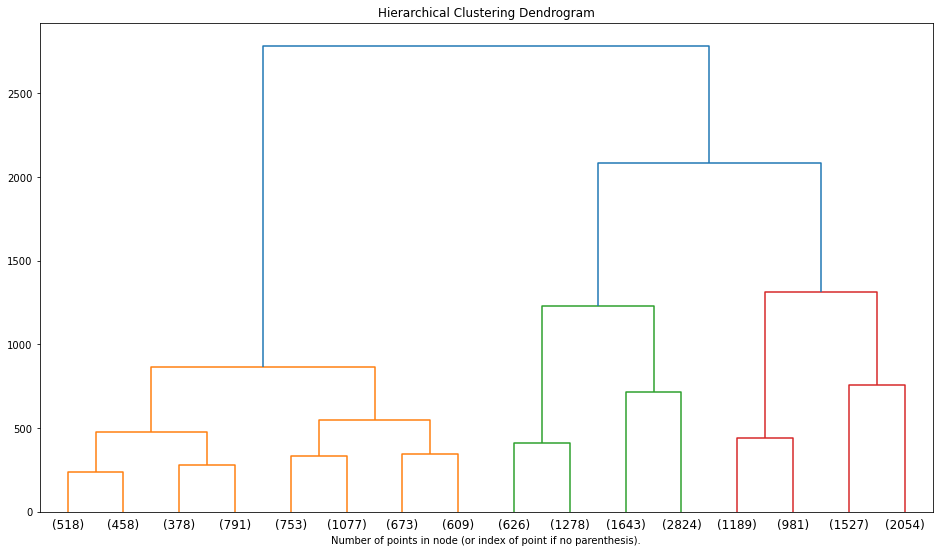

In [61]:
# create clustering for dendogram
clust_dend = AgglomerativeClustering(distance_threshold=0, n_clusters=None)
clust_preds = clust_dend.fit_predict(full_oh_X)

# plot the top 3 levels of the dendrogram
plt.rcParams["figure.figsize"] = [16,9]
plt.title("Hierarchical Clustering Dendrogram")
plot_dendrogram(clust_dend, truncate_mode="level", p=3)
plt.xlabel("Number of points in node (or index of point if no parenthesis).")
plt.show()

<font size="5">
The dendogram shows us that there are 3 main clusters in total, represented by the colors yellow, green and red, where the red and green clusters are closer to each other that with the yellow one. 
</font>
<br/><br/>

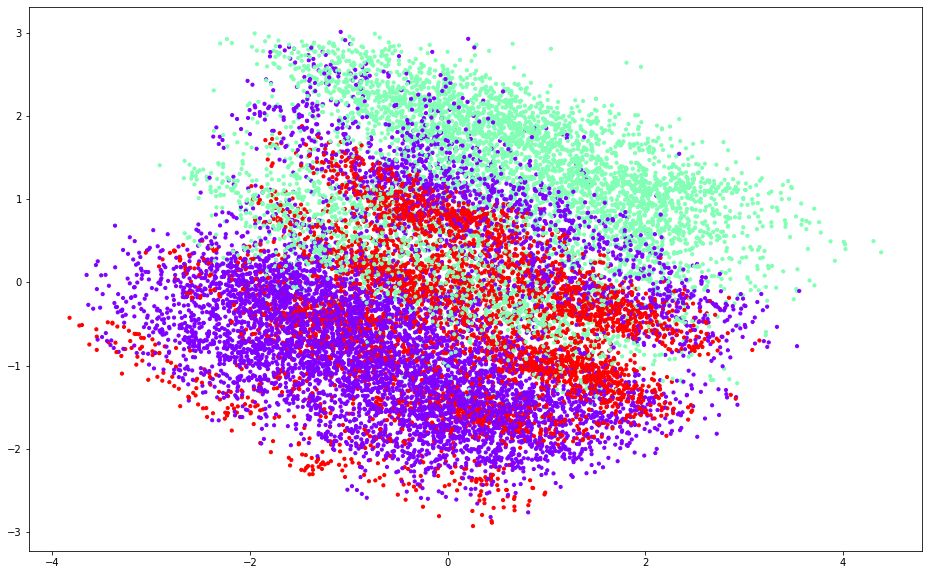

In [71]:
#using clustering on full dataset and projecting clusters on PCA label encoded data
clustering = AgglomerativeClustering(n_clusters=3)
clust_res =  clustering.fit_predict(x_std_label)

fig, ax = plt.subplots(1,1,figsize=(16,10))
ax.scatter(x=pca_transformed_data_label[0],y=pca_transformed_data_label[1],
            c=clust_res, s=10, cmap='rainbow')

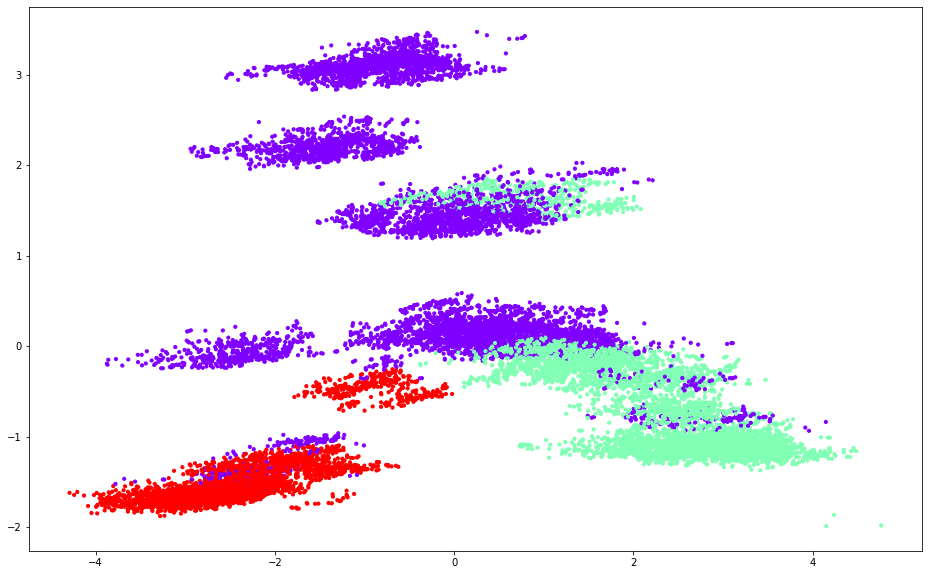

In [73]:
#using clustering directly on PCA transformed data and projecting clusters on PCA one hot encoded data
clustering = AgglomerativeClustering(n_clusters=3)
clust_res =  clustering.fit_predict(x_std_label)

fig, ax = plt.subplots(1,1,figsize=(16,10))
ax.scatter(x=pca_features[0],y=pca_features[1],
            c=clust_res, s=10, cmap='rainbow')

<br/><br/>
<font size='5'>
7.
<font>


<font size="5">
Let's build a random forest regressor model to predict the number of bike rentals.
In order to tune the parameters we will use the random search method. 
</font>

In [64]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor
from scipy.stats import uniform, randint
from sklearn.base import clone


full_oh_X = full_oh_base_df.drop(['Total', 'Subscribed','Non-subscribed'], axis=1).values
full_oh_y = transformed_targets_df['Total_log'].values

full_oh_train_X, full_oh_test_X, full_oh_train_y, full_oh_test_y = train_test_split(full_oh_X, full_oh_y, test_size=0.3, random_state=42)
full_oh_train_X, full_oh_val_X, full_oh_train_y, full_oh_val_y = train_test_split(full_oh_train_X, full_oh_train_y, test_size=0.1, random_state=42)

# built the random forest regressor and set the oob_score to True in order to compare the results later
clf = RandomForestRegressor(oob_score=True, random_state=42)

# create a dictionary with the parameters that we want to tune with random search: n_estimators, max_depth, min_samples_split,min_samples_leaf 
dictr= {'n_estimators': randint(10,150),
       'max_depth': randint(5,200),
       'min_samples_split': uniform(0.0001,0.5),
       'min_samples_leaf': uniform(0.0001,0.5)}

# random search with cv=5 to use a validation set 
clf = RandomizedSearchCV(clf, dictr, random_state=42, cv=5)

# train the model
clf = clf.fit(full_oh_train_X, full_oh_train_y)

print("Best parameters:", clf.best_params_)
print("Best score", clf.best_score_)

Best parameters: {'max_depth': 26, 'min_samples_leaf': 0.0036331526098587028, 'min_samples_split': 0.011631212520707878, 'n_estimators': 68}
Best score 0.7976997086516683


In [65]:
# Scores obtained 
clf= clone(clf.best_estimator_)
clf.fit(full_oh_train_X, full_oh_train_y)
print('OOB train score:', clf.oob_score_)
print('R2 validation score:',clf.score(full_oh_val_X,full_oh_val_y))
print('R2 test score:',clf.score(full_oh_test_X,full_oh_test_y))

OOB train score: 0.7967918309726547
R2 validation score: 0.7900205219500224
R2 test score: 0.7968670067911066


<br/><br/>

<font size="5">
8.<br/>
Finally, the last model is an MLP regressor.
</font>

In [66]:
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import RandomizedSearchCV

#create a dictionary with the parameters that we want to tune with random search
n_hidden = np.linspace(2, 200, 30).astype(int)
n_perc= np.linspace(2, 200, 30).astype(int)

hidden_tuples= []
for i in n_hidden:
  for j in n_perc:
      hidden_tuples.append((i, j))
      
param_space = {
      'hidden_layer_sizes': hidden_tuples,
  }  

full_oh_X = full_oh_base_df.drop(['Total', 'Subscribed','Non-subscribed'], axis=1).values
full_oh_y = transformed_targets_df['Total_log'].values

full_oh_train_X, full_oh_test_X, full_oh_train_y, full_oh_test_y = train_test_split(full_oh_X, full_oh_y, test_size=0.3, random_state=42)

mlp_regr = MLPRegressor(activation='relu', solver='adam', max_iter=10000,
      learning_rate= 'adaptive', early_stopping=True, validation_fraction=0.1, random_state=0)


#  random search with cv=5 to use a validation set 
mlp = RandomizedSearchCV(mlp_regr, param_space, random_state=42, cv=5)
mlp.fit(full_oh_train_X,full_oh_train_y)
print("MLP best params:",mlp.best_params_)

MLP best params: {'hidden_layer_sizes': (165, 77)}


In [67]:
# Creating final MLP model with best hyperparameters
mlp_regr_best = MLPRegressor(activation='relu', solver='adam', max_iter=10000,
      learning_rate= 'adaptive', early_stopping=True, validation_fraction=0.1, random_state=0)
mlp_regr_best.set_params(**mlp.best_params_)

mlp_regr_best.fit(full_oh_train_X, full_oh_train_y)


# Evaluate
pred_mlp_best_train = mlp_regr_best.predict(full_oh_train_X)
pred_mlp_best_test = mlp_regr_best.predict(full_oh_test_X)

r2_score_train = r2_score(full_oh_train_y, pred_mlp_best_train)
r2_score_test = r2_score(full_oh_test_y, pred_mlp_best_test)

print(f'R2 score on train set: \t{r2_score_train} \nR2 score on test set: \t{r2_score_test}')

R2 score on train set: 	0.9359858995805705 
R2 score on test set: 	0.9282803095611943



<font size="5">
From the results we can see that the MLP regressor can reach a satisfactory R2 score, both on the train and test set. We can conclude that the MLP is the best model for this problem.
</font>